In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
mostrecentdate = session.query(measurement.date).order_by(measurement.date.desc()).first()
mostrecentdate

('2017-08-23',)

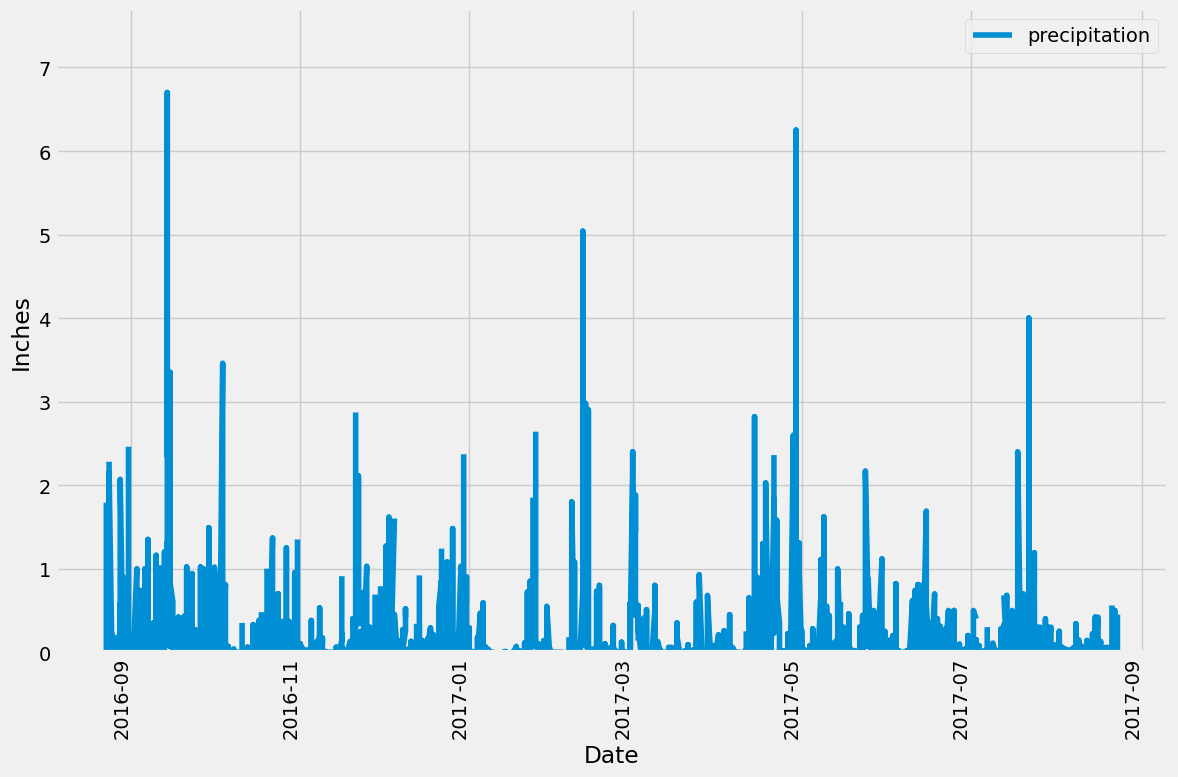

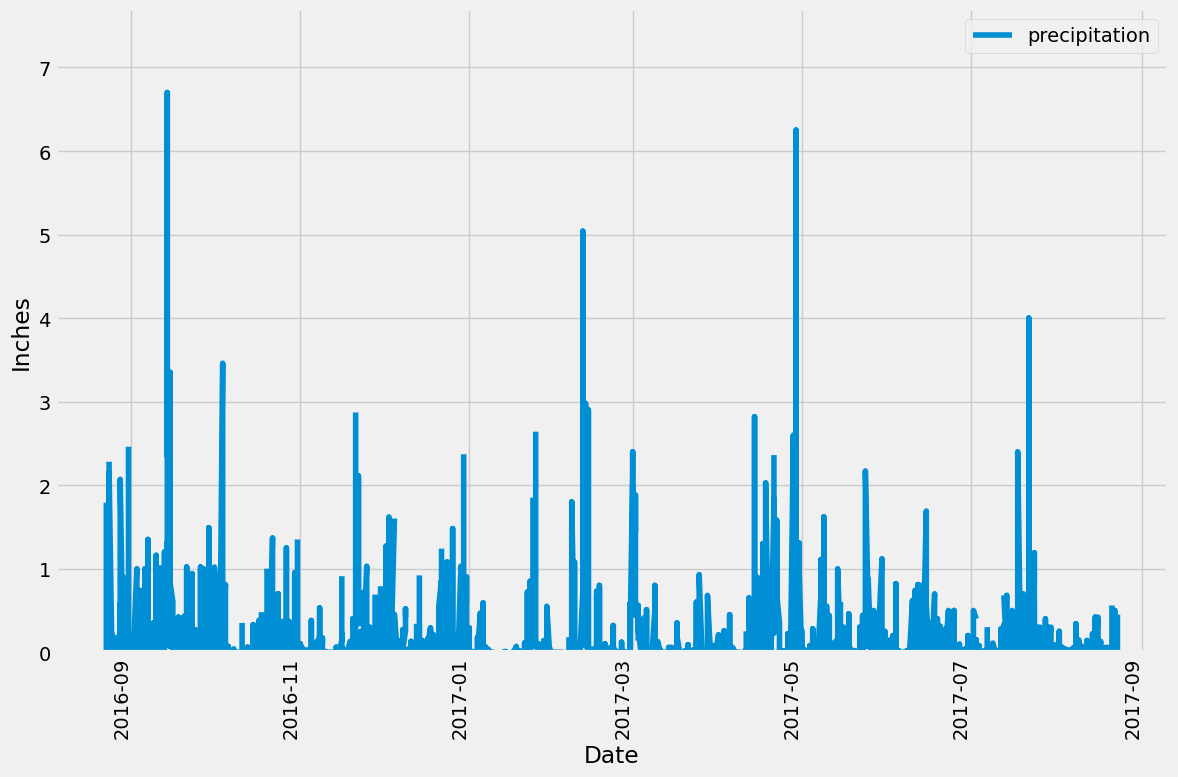

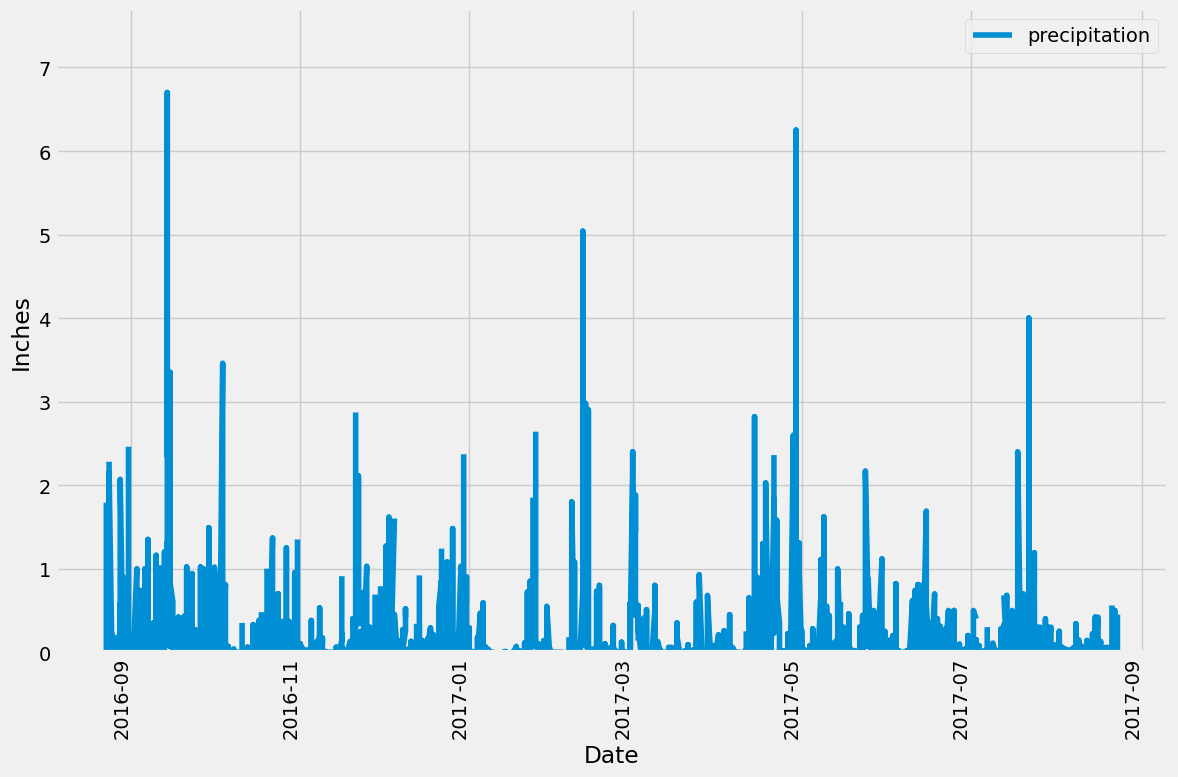

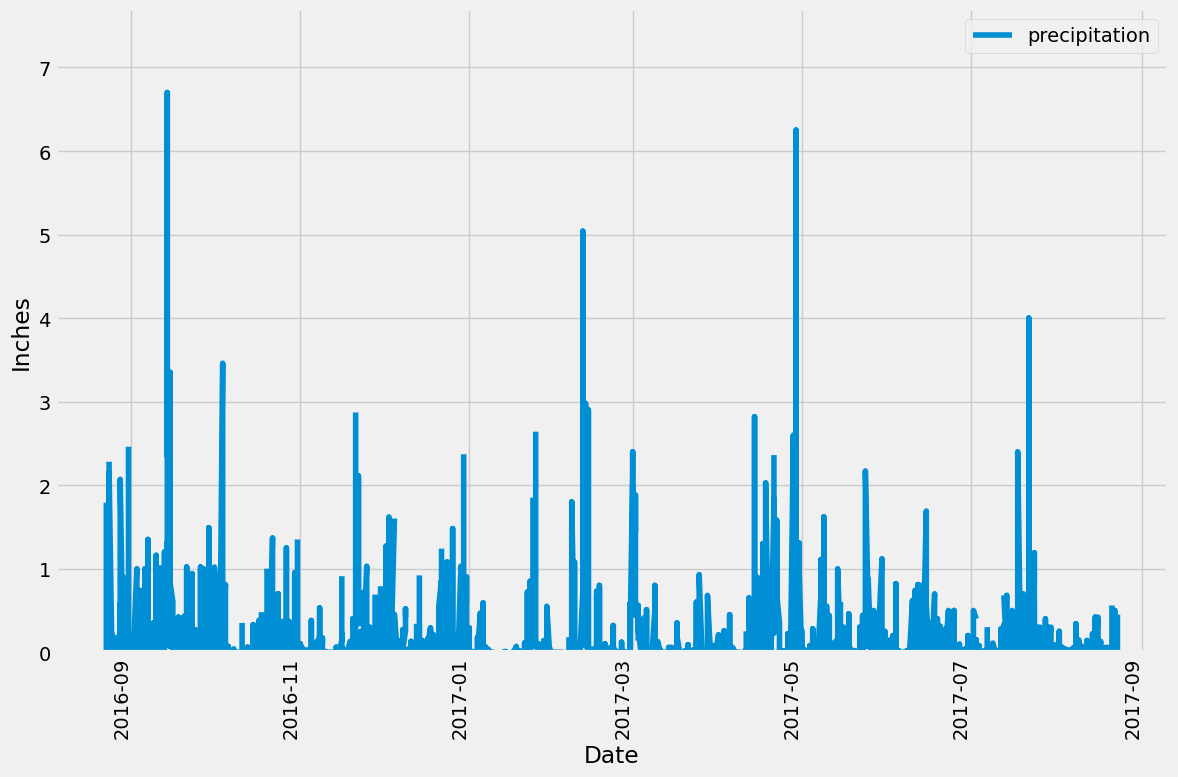

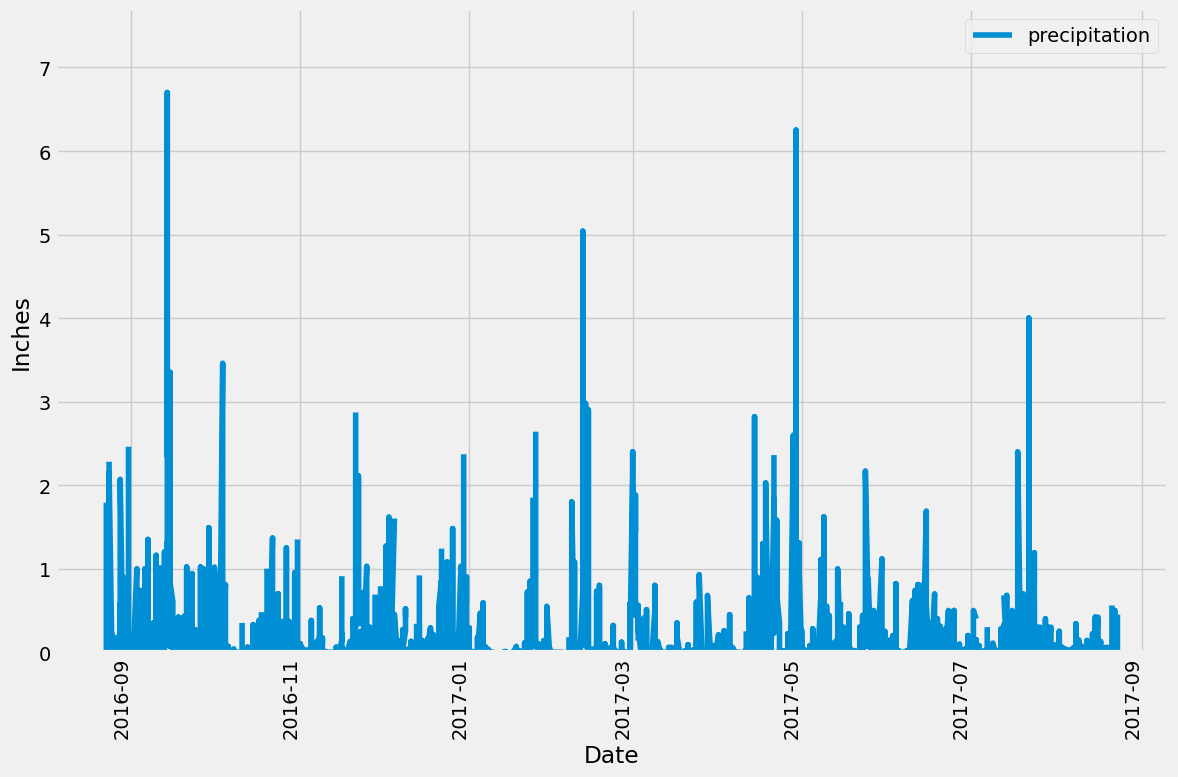

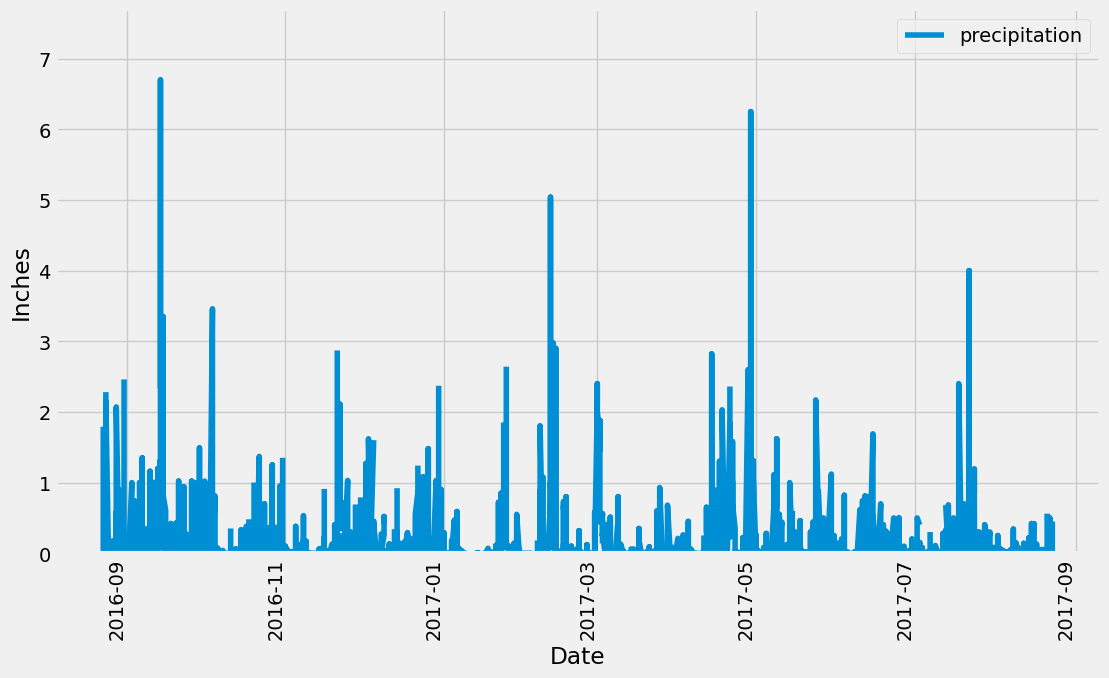

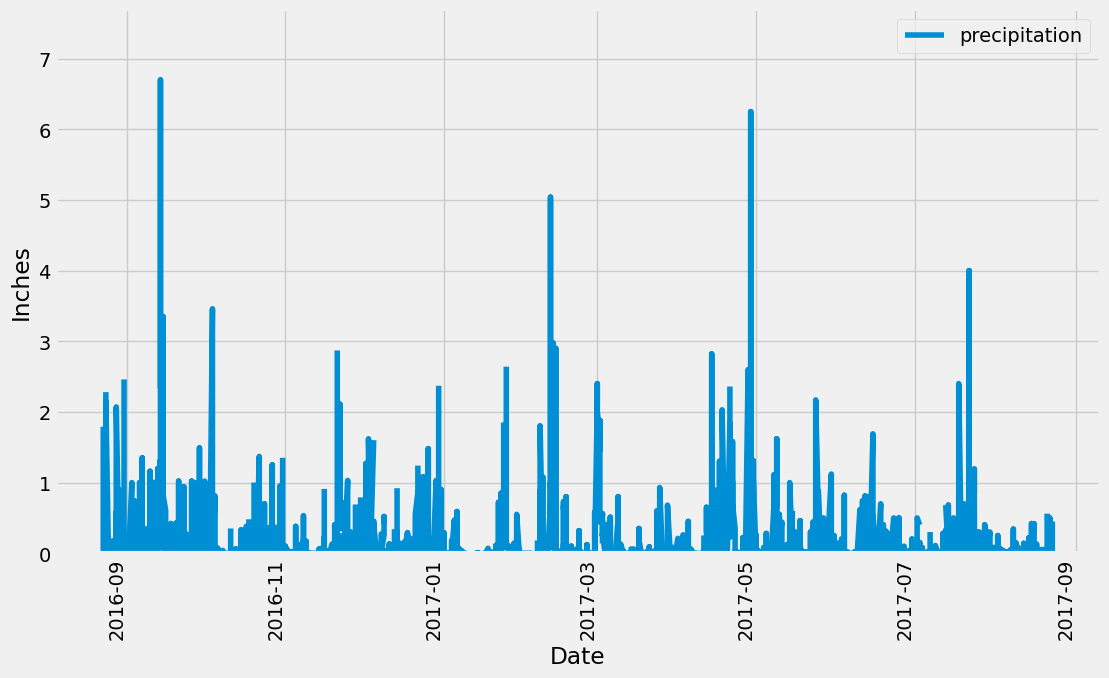

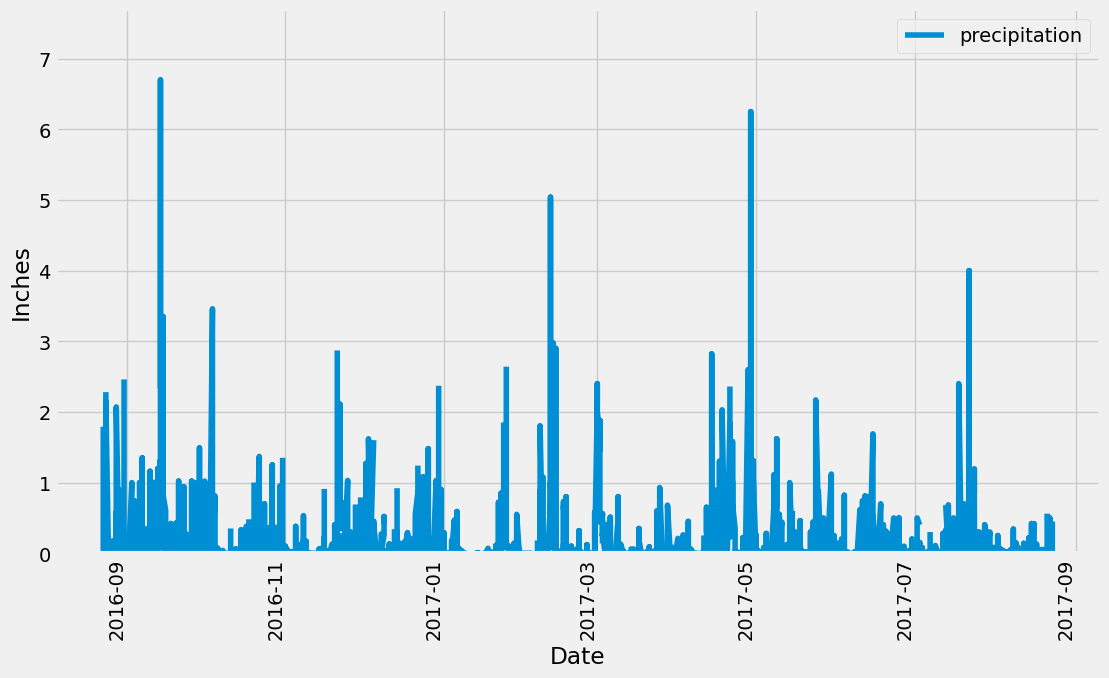

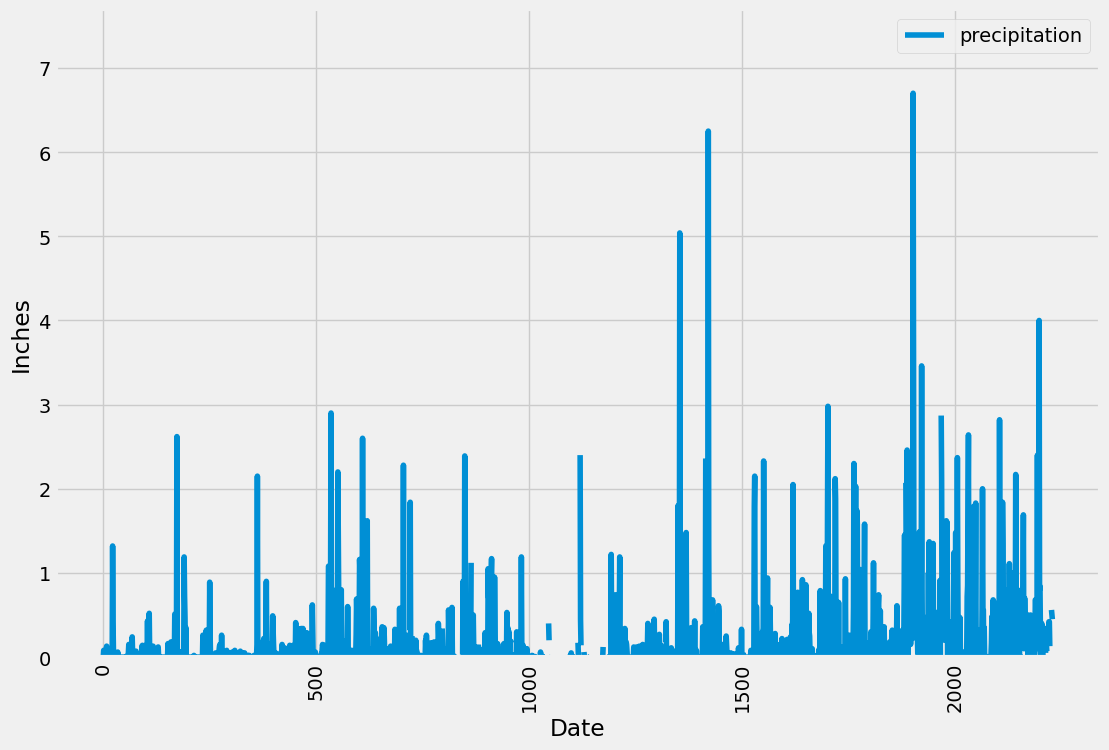

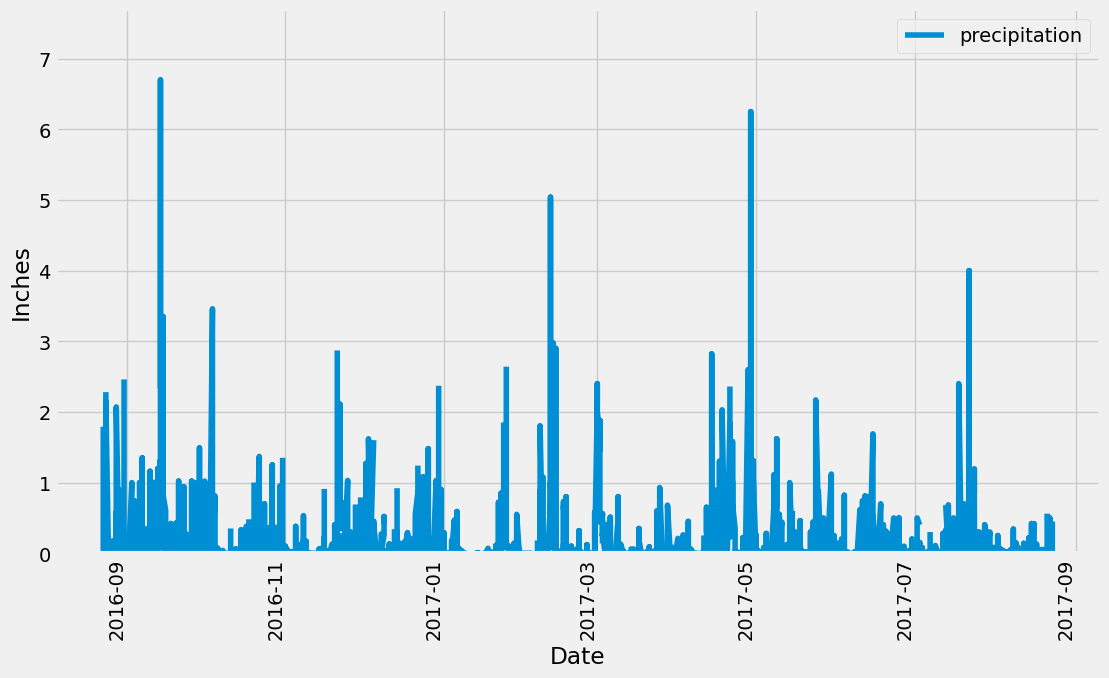

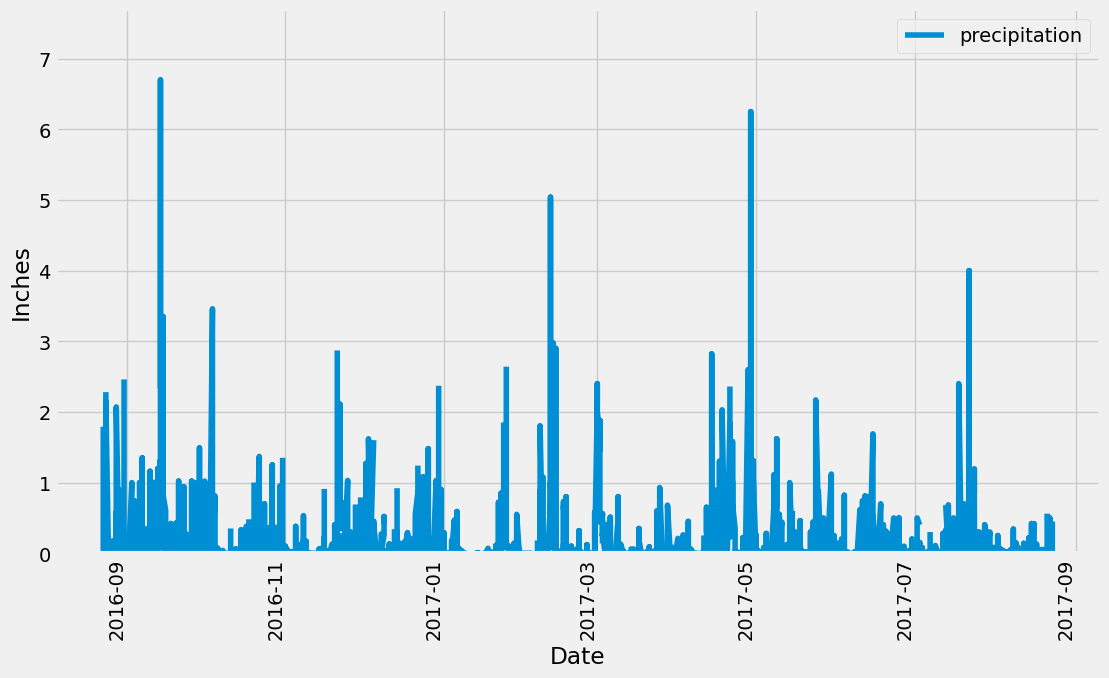

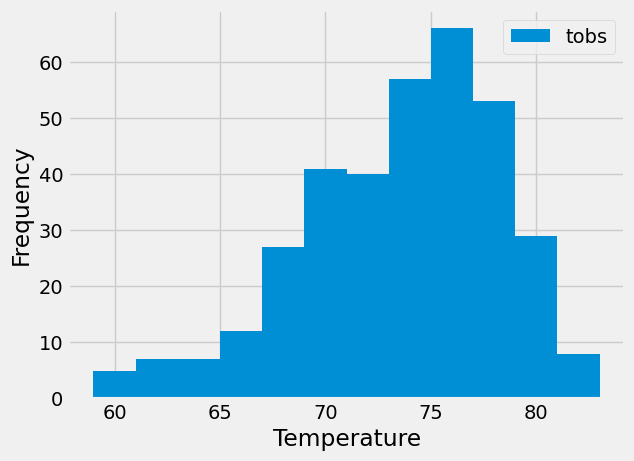

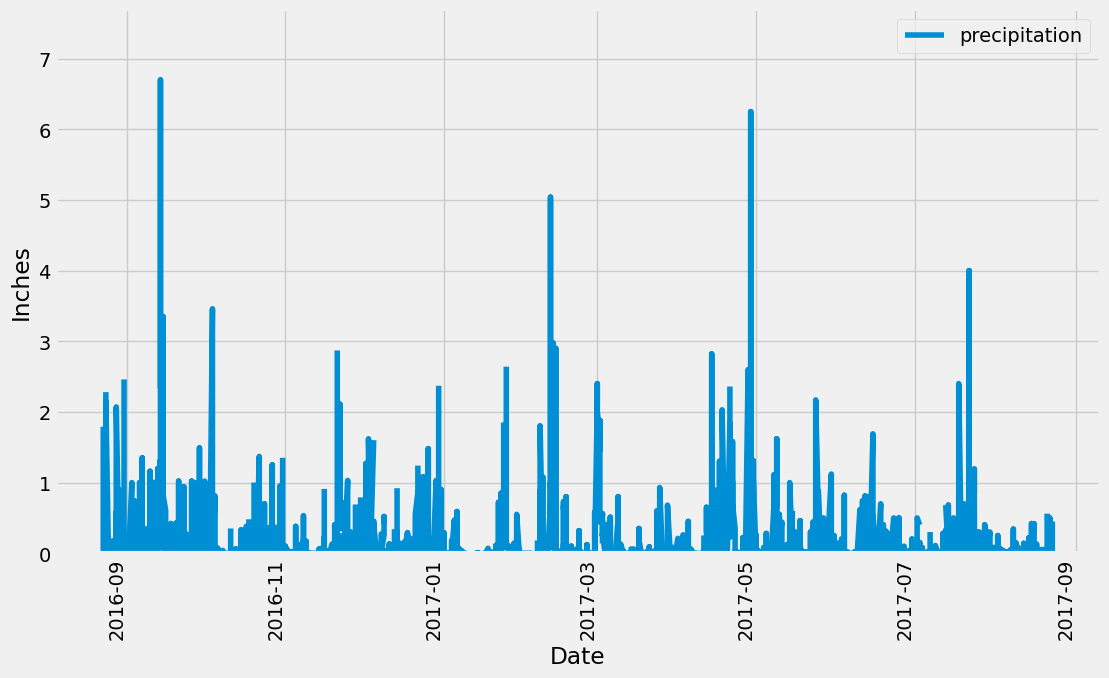

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
mostrecentdate = dt.date(2017,8,23)
# Calculate the date one year from the last date in data set.
year_from_lastdate = recentdate - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
prcpquery = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_from_lastdate).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measurementdf = pd.DataFrame(prcpquery).rename(columns = {'prcp': 'precipitation'})

# Sort the dataframe by date
measurementdf = pd.DataFrame(prcpquery).rename(columns = {'prcp': 'precipitation'})

# Use Pandas Plotting with Matplotlib to plot the data
measurementdf.plot(figsize = (12,8), rot=90)
plt.ylim(0,7.7)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.legend(loc = 'upper right')
plt.show()

In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
measurestats = measurementdf.describe()
measurestats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
session.query(station).first().__dict__
session.query(measurement).first().__dict__
num = len(session.query(station).all())
print(num)

9


In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activestations = session.query(measurement.station,
                              func.count(measurement.id)).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [measurement.station, 
      func.min(measurement.tobs),
      func.max(measurement.tobs),
      func.avg(measurement.tobs)]
most_active = session.query(*sel).filter_by(station = "USC00519281").all()
print(f"{most_active[0][1]}",{most_active[0][2]},{most_active[0][3]})

54.0 {85.0} {71.66378066378067}


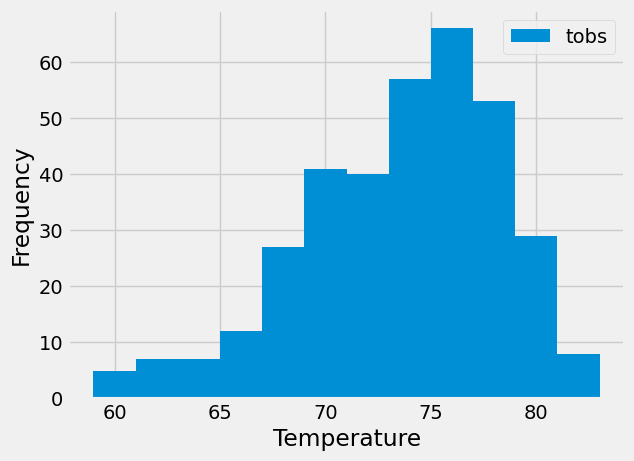

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last12 = session.query(measurement.date, measurement.tobs).filter_by(station = "USC00519281").\
    filter(measurement.date >= year_from_lastdate).all()
last12df = pd.DataFrame(last12)

last12df.plot(kind = 'hist', bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [33]:
# Close Session
date_prcp = session.query(measurement.date, measurement.prcp).all()
num = []
for date, prcp in date_prcp:
    date_dict = {}
    date_dict[date] = prcp
    num.append(date_dict)
session.close()

In [ ]:
#(Help from Tutor below)Create App

In [91]:
from flask import Flask, jsonify
import numpy as np
import datetime as dt
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

In [92]:
def get_session():
    return Session(engine)
app = Flask(__name__)

In [93]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(autoload_with=engine)

In [94]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [95]:
def get_session():
    return Session(engine)

In [96]:
app.route("/")
def welcome():
    """List all available API routes."""
    return """
    <h1>Welcome to the Hawaii Climate API!</h1>
    <h2>Available Routes:</h2>
    <ul>
        <li><a href="/api/v1.0/precipitation">/api/v1.0/precipitation</a> - Last 12 months of precipitation data</li>
        <li><a href="/api/v1.0/stations">/api/v1.0/stations</a> - List of weather stations</li>
        <li><a href="/api/v1.0/tobs">/api/v1.0/tobs</a> - Temperature observations for most active station</li>
        <li>/api/v1.0/&lt;start&gt; - Temperature statistics from start date (format: YYYY-MM-DD)</li>
        <li>/api/v1.0/&lt;start&gt;/&lt;end&gt; - Temperature statistics for date range</li>
    </ul>
    """

In [97]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    """Return last 12 months of precipitation data."""
    session = get_session()
    try:
        # Calculate date one year from last date
        most_recent_date = session.query(func.max(Measurement.date)).first()[0]
        most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()
        one_year_ago = most_recent_date - dt.timedelta(days=365)
 
        # Query precipitation data
        results = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= one_year_ago).all()
 
        # Convert to dictionary
        prcp_dict = {date: prcp for date, prcp in results}
        return jsonify(prcp_dict)
    finally:
        session.close()

In [98]:
@app.route("/api/v1.0/stations")
def stations():
    """Return list of weather stations."""
    session = get_session()
    try:
        # Query all stations
        results = session.query(Station.station, Station.name).all()
        station_list = [{"station": station, "name": name} for station, name in results]
        return jsonify(station_list)
    finally:
        session.close()

In [99]:
@app.route("/api/v1.0/tobs")
def tobs():
    """Return temperature observations for most active station."""
    session = get_session()
    try:
        # Find most active station
        most_active_station = session.query(Measurement.station).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).first()[0]
 
        # Calculate date one year ago
        most_recent_date = session.query(func.max(Measurement.date)).\
            filter(Measurement.station == most_active_station).first()[0]
        most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()
        one_year_ago = most_recent_date - dt.timedelta(days=365)
 
        # Query temperature data
        results = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.station == most_active_station).\
            filter(Measurement.date >= one_year_ago).all()
 
        temps_list = [{"date": date, "temperature": temp} for date, temp in results]
        return jsonify(temps_list)
    finally:
        session.close()

In [ ]:
@app.route("/api/v1.0/<start>")
@app.route("/api/v1.0/<start>/<end>")
def temp_stats(start, end=None):
    """Return temperature statistics for date range."""
    session = get_session()
    try:
        # Parse dates
        start_date = dt.datetime.strptime(start, '%Y-%m-%d')
        if end:
            end_date = dt.datetime.strptime(end, '%Y-%m-%d')
 
        # Select temperature calculations
        sel = [func.min(Measurement.tobs).label('min_temp'),
               func.avg(Measurement.tobs).label('avg_temp'),
               func.max(Measurement.tobs).label('max_temp')]
 
        # Query with or without end date
        if end:
            results = session.query(*sel).\
                filter(Measurement.date >= start_date).\
                filter(Measurement.date <= end_date).all()
        else:
            results = session.query(*sel).\
                filter(Measurement.date >= start_date).all()
 
        stats_dict = {
            "start_date": start,
            "end_date": end if end else "Present",
            "min_temp": results[0][0],
            "avg_temp": round(results[0][1], 1),
            "max_temp": results[0][2]
        }
        return jsonify(stats_dict)
    finally:
        session.close()
 
if __name__ == '__main__':
    app.run(debug=True)